# Лабораторная работа №7

# Задание

Создать и сравнить три вида ансамблей (Average, WeightedAverageLayer, Stacking Ensemble) на основе моделей бинарной сегментации поврежденных областей леса.



# Задания для самостоятельной работы

1. Попробуйте разные комбинации моделей в ансамбле, поменяйте их количество
2. Подберите лучшие веса для WeightedAverageLayer
3. Поменяйте выходную часть в Stacking Ensemble (количество слоёв, их параметры)

# Контрольные вопросы для защиты

1. Что такое ансамбль моделей? Meta-learner?
2. Способы объединения моделей в ансамбль
3. Архитектура U-Net
4. Выходные слои нейронной сети для сегментации
5. Оценка качества сегментации. Dice коэффициент.

# Импортирование библиотек

In [1]:
import cv2
import os
import glob
import numpy as np
import pandas as pd
from skimage import io
import random

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import (EarlyStopping,
                                        ModelCheckpoint,
                                        ReduceLROnPlateau,
                                        CSVLogger,
                                        TensorBoard,
                                        LearningRateScheduler
                                       )
from tensorflow.keras.utils import Sequence
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanIoU
import tensorflow.keras.backend as K
from tensorflow.keras.losses import binary_crossentropy
from keras.layers import concatenate
from keras.utils import plot_model

from imgaug import augmenters as iaa

In [2]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import colors
import matplotlib as mpl
from PIL import ImageEnhance

In [3]:
from tensorflow import summary as tfsummary
from datetime import datetime
from tensorflow.python.client import device_lib

%matplotlib inline
%load_ext tensorboard

tf.random.set_seed(42)

Keras по умолчанию использует Tensorflow под капотом. Хотя можно использовать другие библиотеки. Нужно убедиться, что он знает про сущестование GPU на устройстве. Вывод device_lib.list_local_devices() должен быть что-то типа:
```
[
  name: "/cpu:0"device_type: "CPU",
  name: "/gpu:0"device_type: "GPU"
]
```

**Если не выводит GPU, у вас проблема**

In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 1465345140704399947
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14626652160
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 13694149082525287000
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419]

In [6]:
!nvidia-smi

Thu May  9 17:31:09 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   74C    P0              32W /  70W |    103MiB / 15360MiB |      3%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Загрузка данных

In [7]:
%%script echo skipping

!mkdir data

!wget -O data/tiles_256_256_27_test.tar.gz "https://www.dropbox.com/s/x67dbq18z52kmzx/tiles_256_256_27_test.tar.gz?dl=0" # Должен быть 211,05 МБ
!wget -O data/tiles_256_256_27_train.tar.gz "https://www.dropbox.com/s/2sqhjj6l537d277/tiles_256_256_27_train.tar.gz?dl=0" # 892,14 МБ
!wget -O data/files.tar.gz "https://www.dropbox.com/s/uoinrn61ekn3m6h/files.tar.gz?dl=0" # 22,24 МБ

# нифига не скачивает
# !wget -O data/fchecksum https://www.dropbox.com/scl/fi/hsj9ndzltuyow7rq2ghe7/fchecksum?rlkey=9sh4co03ya98qolgoe82bbyip&st=yqtnjm67&dl=0
# !wget -O data/testchecksum https://www.dropbox.com/scl/fi/r30th0h1lhdyxmc0y3j6i/testchecksum?rlkey=81yrjtbkxpfx3atqmx0i638jn&st=ae4i0ekt&dl=0
# !wget -O data/trainchecksum https://www.dropbox.com/scl/fi/ok8q8izv4thfxua47rmfl/trainchecksum?rlkey=t0hofvuw6gopvou4yh4r4t1sw&st=2novlbch&dl=0

# Но чексумма есть в АПИ
# https://www.dropbox.com/developers/documentation/http/documentation#sharing-get_file_metadata
# https://www.dropbox.com/developers/documentation/http/documentation#file_requests-get
# но где блин брать ID
# https://www.dropboxforum.com/t5/Dropbox-API-Support-Feedback/From-Where-I-can-get-the-File-ID/td-p/255267
# Без аксесс-токена ничего работать не будет

skipping


In [8]:
# Проверка размеров
!ls -lah data/

total 1.1G
drwxr-xr-x   5 root root  4.0K May  9 14:45 .
drwxr-xr-x   1 root root  4.0K May  9 15:44 ..
drwxr-xr-x   2  501 staff 4.0K Mar 13  2023 files
-rw-r--r--   1 root root   23M May  9 14:44 files.tar.gz
drwxr-xr-x 117  501 staff  12K Mar 13  2023 tiles_256_256_27_test
-rw-r--r--   1 root root  212M May  9 14:43 tiles_256_256_27_test.tar.gz
drwxr-xr-x  29  501 staff 4.0K Mar 13  2023 tiles_256_256_27_train
-rw-r--r--   1 root root  893M May  9 14:44 tiles_256_256_27_train.tar.gz


In [9]:
# !sha256sum --check data/fchecksum
# !sha256sum --check data/testchecksum
# !sha256sum --check data/trainchecksum

In [10]:
%%script echo skipping
!tar -xf data/tiles_256_256_27_test.tar.gz -C data/
!tar -xzf data/tiles_256_256_27_train.tar.gz -C data/
!tar -xzf data/files.tar.gz -C data/

!mv data/tiles_256_256_27_after_check_test data/tiles_256_256_27_train

skipping


In [11]:
# from google.colab import drive
# drive.mount('/content/drive')

# local_download_path = "/content/drive/My Drive/Colab Notebooks"
local_download_path = 'data/'

## Архитектура U-net

In [12]:
def conv_block(x, num_filters):
    x = Conv2D(num_filters, (3, 3), padding="same")(x)
    #x = Dropout(0.5)(x)#my add default None
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, (3, 3), padding="same")(x)
   # x = Dropout(0.5)(x)#my add default None
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def build_model(size = 256,channels=6):
    num_filters = [16, 32, 48, 64] # original
    inputs = Input((size, size, channels))

    skip_x = []
    x = inputs

    ## Encoder
    for f in num_filters:
        x = conv_block(x, f)
        skip_x.append(x)
        x = MaxPool2D((2, 2))(x)
        x = Dropout(0.5)(x)

    ## Bridge
    x = conv_block(x, num_filters[-1])

    num_filters.reverse()
    skip_x.reverse()

    ## Decoder
    for i, f in enumerate(num_filters):
        x = UpSampling2D((2, 2))(x)
        xs = skip_x[i]
        x = Concatenate()([x, xs])
        x = Dropout(0.5)(x)
        x = conv_block(x, f)

    ## Output
    x = Conv2D(1, (1, 1), padding="same")(x)
    x = Activation("sigmoid")(x)

    return Model(inputs, x)

## Подготовка данных - Датасет

Для подготовки данных в keras есть стандартный ImageGenerator, с помощью которого можно нормализовать изображения, добавить аугументации к данным, отделить данные для валидации и т. д.

Вместо этого мы реализуем собственный DataGenerator для обработки мультиспектральных данных.
На вход модели будем подавать набор из части исходных каналов, некоторых разностей, а также NDVI индекс, о котором мы говорили в предыдущем разделе. Наиболее удачный набор каналов был определен экспериментально. В дальнейшем при использовании обученной модели необходимо будет выделять из тестовых изображений тот же самый набор каналов

Также к формируемому батчу в getitem можно применить аугументации с помощью imgaug. Аугментация данных — это методика создания дополнительных данных из имеющихся данных.
Полный список возможных аугументаций: https://imgaug.readthedocs.io/en/latest/source/overview_of_augmenters.html

In [13]:
# тут рассчитываем входные признаки (производные или исходные и т.д.)
def prepare_snaps(img):
    return np.array(
            np.dstack([
                    img[:,:,4],
                    img[:,:,8],
                    img[:,:,17],
                    img[:,:,21],
                    img[:,:,4] - img[:,:,17], # dif red
                    img[:,:,17] - img[:,:,4], # dif for transitionChange
                    img[:,:,8] - img[:,:,21],
                    img[:,:,21] - img[:,:,8],
                    img[:,:,13],
                    img[:,:,26],
                    img[:,:,13] - img[:,:,26],
                    img[:,:,26] - img[:,:,13], # dif for transitionChange
                    img[:,:,12], # dif for transitionChange
                    img[:,:,25], # dif for transitionChange
                    img[:,:,12] - img[:,:,25], # dif for transitionChange
                    img[:,:,25] - img[:,:,12],
                ])).astype('float32')

class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, inputTiffs, batch_size=32, num_classes=2, num_models=1, shuffle=True):
        self.inputTiffs = inputTiffs
        self.batch_size = batch_size
        self.num_classes = num_classes
        self.num_models = num_models
        self.shuffle = shuffle
        self.on_epoch_end()
        #custom augmentation with imgaug lib
        self.aug_pipe = iaa.Sequential(
            [
                iaa.SomeOf((0,2),
                [
                    #iaa.Add((-30, -10)), # change brightness of images (by -10 to 10 of original value)
                    #iaa.Multiply((0.8, 1.2)),

                    # Geometric transfroms
                    iaa.Rotate((-45,45)),
                    iaa.TranslateX(px=(-20, 20)),
                    iaa.TranslateY(px=(-20, 20)),
                ]
                ),
            ],
            random_order=True
        )

    def __len__(self):
        return len(self.inputTiffs) // self.batch_size

    def __getitem__(self, index):
        indexes = self.index[index * self.batch_size:(index + 1) * self.batch_size]
        batchTifs = [self.inputTiffs[k] for k in indexes]
        # self.aug_pipe(images=batchTifs)

        X, y = self._get_data(batchTifs)

        if self.num_models > 1:
          X = [X for _ in range(self.num_models)]

        print('DataGenerator X =', X, 'y =', y)
        return X, y

    def on_epoch_end(self):
        self.index = np.arange(len(self.inputTiffs))
        if self.shuffle == True:
            np.random.shuffle(self.index)

    def _get_data(self, batch):
        X = []
        y = []

        for idx,imagePath in enumerate(batch):
            img = (io.imread(imagePath)/65536).astype('float32')

            # здесь важно учесть, сколько классов мы хотим
            # сейчас все лесные повреждения сводятся к одному
            y.append(np.where(img[:,:,0]>0,1,0).astype('int'))
            # y.append(np.where(img[:,:,0]==1/65536,1,0).astype('int'))

            X.append(prepare_snaps(img))

        return np.array(X), np.array(y)

    def flip(self,image):
        flipDirection = np.random.randint(-1,1,1)[0]
        return cv2.flip(image,flipDirection)

## Метрики

## Гиперпараметры

# Часть 2. Ансамблирование моделей нейронных сетей

Нейронные сети учатся с помощью стохастических алгоритмов, так что они могут находить каждый раз разные наборы весов и в свою очередь делать разные прогнозы. Для уменьшения разброса предсказаний можно обучить нескольких моделей вместо одной и объединенить результаты этих моделей. Ансамбль моделей может оказаться более стабильным, а иногда и более эффективным решением.

Важно, чтобы модели в ансамбле были хороши по-разному и делали разные ошибки, которые могут затем взаимно компенсировать. Можно варьировать данные для обучения, гиперпараметры, архитектуры подмоделей.

В примере используются несколько unet-моделей с разными функциями потерь.

## Датасет для ансамблевых моделей

In [14]:
# Датасет

# В allTiles именно файлы train/*/*with_object.tif. allTiles используются только для демонстрации данных в датасете
# Модель в ч.1 обучается на данных, представленных переменной trainTiles и validTiles. Обе - данные из tiles_256_256_27_train/*/*.tif в пропорции 85 к 15
# Модель в ч.2 обучается на данных, представленных переменной trainTiles и testTiles из tiles_256_256_27_train/*/*.tif и tiles_256_256_27_train/*/*.tif соответственно

testTiles = list(glob.glob(local_download_path + 'tiles_256_256_27_test/*/*.tif'))
print('test len', len(testTiles))

trainTiles = list(glob.glob(local_download_path + 'tiles_256_256_27_train/*/*.tif'))
print('train len', len(trainTiles))

test len 117
train len 572


Давным-давно в keras способ сохранения моделей был измене. Тут я проверяю, нормально ли все загружается

In [15]:
import h5py
f1 = h5py.File(local_download_path + 'files/model186_dice.h5', 'r')
f2 = h5py.File(local_download_path + 'files/model230_bc.h5', 'r')
f3 = h5py.File(local_download_path + 'files/model230_tversky.h5', 'r')
f4 = h5py.File(local_download_path + 'files/model230_dice_bc.h5', 'r')
f5 = h5py.File(local_download_path + 'files/model_dice_wind.h5', 'r')

archs = list(map(lambda x: x.attrs.get('model_config'), [f1, f2, f3, f4, f5]))

# Модели f1, f2, ... равны между собой по архитектуре
print(all([arch_a == arch_b for arch_a in archs for arch_b in archs])) # True
# Вроде как это та же модель, что описана в build_model в ч.1., но из-за особенностей сохранения новая модель описывается JSON'ом на 4800 строк, в то время как старая - 2700
print(f1.attrs.get('model_config') == build_model(size=256,channels=16).to_json()) # False

# Это в новых версиях Keras на Kaggle
# Загружаем старую и сравниваем с новой. JSON у загруженной имеет такое же количество строк, вроде бы одна и та же архитектура, но JSON'ы не равны
# model1 = build_model(size=256,channels=16)
# model1.load_weights(local_download_path + 'files/model186_dice.h5')
# print(model1.to_json() == build_model(size=256,channels=16).to_json()) # False

True
False


In [16]:
# В Colab
model1 = tf.keras.models.load_model(local_download_path + 'files/model186_dice.h5', compile=False)
model2 = tf.keras.models.load_model(local_download_path + 'files/model230_bc.h5', compile=False)
model3 = tf.keras.models.load_model(local_download_path + 'files/model230_tversky.h5', compile=False)
model4 = tf.keras.models.load_model(local_download_path + 'files/model230_dice_bc.h5', compile=False)
model5 = tf.keras.models.load_model(local_download_path + 'files/model_dice_wind.h5', compile=False)
model1._name = 'model_1'
model2._name = 'model_2'
model3._name = 'model_3'
model4._name = 'model_4'
model5._name = 'model_5'


# В Kaggle
# model1 = build_model(size=256,channels=16)
# model1.load_weights(local_download_path + 'files/model186_dice.h5')
# model1._name = 'model_1'

# model2 = build_model(size=256,channels=16)
# model2.load_weights(local_download_path + 'files/model230_bc.h5')
# model2._name = 'model_2'

# model3 = build_model(size=256,channels=16)
# model3.load_weights(local_download_path + 'files/model230_tversky.h5')
# model3._name = 'model_3'

# model4 = build_model(size=256,channels=16)
# model4.load_weights(local_download_path + 'files/model230_dice_bc.h5')
# model4._name = 'model_4'

# model5 = build_model(size=256,channels=16)
# model5.load_weights(local_download_path + 'files/model_dice_wind.h5')
# model5._name = 'model_5'

In [17]:
def dice_loss(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)

    return 1 - numerator / denominator


def dice_coefficient(y_true, y_pred, smooth=1):
    try:
        y_true = K.cast(y_true, 'float32')
        y_pred = K.cast(y_pred, 'float32')
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true_f * y_pred_f)
        return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    except Exception as e:
        print(e)
        print(y_true_f)
        print(y_pred_f)
        # print(intersection)
        raise e;


def round_original(a):
    new = [1 if i > 0 else 0 for i in a]
    return np.array (new)


def predict(model, testTiles, num_models=1):
  print(num_models)
  original_list = []

  original_img_list = []

  predict_mask_list = []

  for testImg in testTiles:
      img = io.imread(testImg)
      original_img_list.append( img )
      img = img /65536
      original_list.append( np.apply_along_axis( round_original, 1, img[:,:,0] ).astype('float32') )

      toPredict = prepare_snaps(img)

      if num_models==1:
        testPrediction = model.predict(np.array([toPredict]));
      else:
        print('here')
        testPrediction = model.predict([np.array([toPredict]) for _ in range(num_models) ]);

      predict_mask_list.append(testPrediction[0,:,:,0].astype('float32'))

  dice = dice_coefficient(original_list, predict_mask_list)

  return dice, original_img_list, predict_mask_list

## Усреднение прогнозов моделей

Самый простой способ объединения предсказания подмоделей - это рассчитать их среднее значение. Также можно добавить веса, чтобы сделать более ощутимым вклад удачных моделей.

In [18]:
# Гиперпараметры для WeightedAverage

# •	Dice Score for model1 = 0.7865361
# •	Dice Score for model2 = 0.72723323
# •	Dice Score for model3 = 0.7729393
# •	Dice Score for model4 = 0.76732963
# •	Dice Score for model5 = 0.6782828
# Dice: model1 > model3 > model4 > model2 > model5

# members = [model3, model5] # По умолчанию
# weights = [0.6, 0.3] # По умолчанию

# 2
# members = [model1, model3, model4]
# weights = [1/3, 1/3, 1/3]

# 3
# members = [model1, model3, model4, model2]
# weights = [0.25, 0.25, 0.25, 0.25]

# 4
# members = [model1, model2, model3, model4, model5]
# weights = [0.2, 0.2, 0.2, 0.2, 0.2]

# members = [model1, model2, model3, model4, model5]
# weights = [0.4, 0.02, 0.08, 0.4, 0.1]
# weights = [0.05, 0.3, 0.5, 0.05, 0.1]

members = [model1, model3, model5]
weights = [0.9, 0.05, 0.05]

In [19]:
MODEL_NAME = datetime.now().strftime("%d.%m-%H:%M:%S") + "_" + "_".join(map(lambda x: x._name.replace("_", ""), members))  # даты будут -3 часа, т.к. часовой пояс на сервере Kaggle - UTC +0
os.environ["MODEL_NAME"] = MODEL_NAME # буду использовать для названия zip-архива в unix-команде
MODEL_NAME

'09.05-17:31:22_model1_model3_model5'

Мы не собираемся менять подмодели, так что сделаем их слои необучаемыми. Также переименуем их, чтобы избежать 'unique layer name' ошибки

In [20]:
for i in range(len(members)):
  model = members[i]
  for layer in model.layers:
      layer.trainable = False
      layer._name = 'ensemble_' + str(i+1) + '_' + layer.name

In [21]:
print("Количество слоёв в базовой модели: ", len(model2.layers))

print("weights:", len(model2.weights))
print("trainable_weights:", len(model2.trainable_weights))
print("non_trainable_weights:", len(model2.non_trainable_weights))

Количество слоёв в базовой модели:  77
weights: 110
trainable_weights: 74
non_trainable_weights: 36


In [22]:
# class WeightedAverageLayer(tf.keras.layers.Layer):
#     def __init__(self, w1, w2, w3, w4, w5, **kwargs):
#         super(WeightedAverageLayer, self).__init__(**kwargs)
#         self.w1 = w1
#         self.w2 = w2
#         self.w3 = w3
#         self.w4 = w4
#         self.w5 = w5

#     def call(self, inputs):
#         return self.w1 * inputs[0] + self.w2 * inputs[1] + self.w3 * inputs[2] + self.w4 * inputs[3] + self.w5 * inputs[4]

class WeightedAverageLayer(tf.keras.layers.Layer):
    def __init__(self, my_weights, **kwargs):
        super(WeightedAverageLayer, self).__init__(**kwargs)
        self.my_weights = my_weights

    def call(self, inputs):
        # print(inputs)
        # [<tf.Tensor 'Placeholder:0' shape=(None, 256, 256, 1) dtype=float32>, <tf.Tensor 'Placeholder_1:0' shape=(None, 256, 256, 1) dtype=float32>, <tf.Tensor 'Placeholder_2:0' shape=(None, 256, 256, 1) dtype=float32>]
        res = 0
        for i, inpt in enumerate(inputs):
            res += inpt * self.my_weights[i]
        return res

### Ансамблевая модель WeightedAverageLayer

In [23]:
model_input = tf.keras.Input(shape=(256, 256, 16))
model_outputs = [model(model_input) for model in members]
ensemble_output = WeightedAverageLayer(weights)(model_outputs)
ensemble_model = tf.keras.Model(inputs=model_input, outputs=ensemble_output)

In [24]:
# plot_model(ensemble_model, show_shapes=True, show_layer_names=True, to_file='model_graph.png')

### Оценка моделей по отдельности и ансамблевой модели WeightedAverageLayer


In [25]:
%%capture

# Все 6 оценок - 2 мин 30 сек на GPU
# model1-model5 Достаточно прогнать 1 раз
# dice1 = predict(model1, testTiles)[0]
# dice2 = predict(model2, testTiles)[0]
# dice3 = predict(model3, testTiles)[0]
# dice4 = predict(model4, testTiles)[0]
# dice5 = predict(model5, testTiles)[0]

dice_ensemble = predict(ensemble_model, testTiles)[0]

In [26]:
# model1-model5 Достаточно прогнать 1 раз
# print('Dice Score for model1 =', dice1.numpy())
# print('Dice Score for model2 =', dice2.numpy())
# print('Dice Score for model3 =', dice3.numpy())
# print('Dice Score for model4 =', dice4.numpy())
# print('Dice Score for model5 =', dice5.numpy())

print('ModelName =', MODEL_NAME, 'Weights=', str(weights).replace('.', ','), 'Dice Score for ensemble =', str(dice_ensemble.numpy()).replace('.', ','))

ModelName = 09.05-17:31:22_model1_model3_model5 Weights= [0,9, 0,05, 0,05] Dice Score for ensemble = 0,7808494


In [27]:
raise Exception('stop')

Exception: stop

## Stacking Ensemble

Мы можем обучить мета-ученика, который будет сочетать прогнозы из подмоделей и в идеале делать предсказания точнее, чем любая отдельная подмодель. В качестве мета-ученика можно использовать МЛ-модель (линейную регрессию и т.д.) или нейронную сеть. Во втором случае можно рассматривать стековый ансамбль как единую большую модель (multi-headed model). Подмодели могут быть встроены в более крупную многоголовую нейронную сеть, которая затем учится, как лучше всего комбинировать прогнозы из каждой входной подмодели.



In [41]:
# Гиперпараметры

# Dice: model1 > model3 > model4 > model2 > model5

members = [model1, model3, model4]
# members = [model1, model2, model3, model4, model5]

# batch = 8 # По умолчанию
# epochs = 5 # По умолчанию
# lr = 4e-3 # По умолчанию
# hidden_size = 16 # По умолчанию

batch = 8
epochs = 5
lr = 4e-3
hidden_size = 32

In [42]:
MODEL_NAME = datetime.now().strftime("%d.%m-%H:%M:%S") + "_" + "_".join(map(lambda x: x._name.replace("_", ""), members))  # даты будут -3 часа, т.к. часовой пояс на сервере Kaggle - UTC +0
os.environ["MODEL_NAME"] = MODEL_NAME # буду использовать для названия zip-архива в unix-команде
MODEL_NAME

'09.05-17:47:06_model1_model3_model4'

In [43]:
# Датасет

validSize = int(len(trainTiles)*0.15)
print(validSize)

train_generator = DataGenerator(trainTiles[:-validSize],batch_size=batch,num_models=len(members))
valid_generator = DataGenerator(trainTiles[-validSize:],batch_size=batch,num_models=len(members))

85


Входному слою каждой подмодели нужно предоставить свои входные данные (в данном случае одинаковые). Так что всей multi-headed модели нужно будет предоставить k копий входных данных, на основе которых уже будут сделаны предсказания.

Потом результаты каждой из моделей можно объединить с помощью простой конкатенации.

Затем скрытый слой будет подбирать веса для интерпретации этого «ввода», а выходной слой (сверточный+активация sigmoid) делать свой собственный вероятностный прогноз.

### Обучение Stacking Ensemble

In [44]:
for i in range(len(members)):
  model = members[i]
  for layer in model.layers:
      layer.trainable = False
      layer._name = 'ensemble_' + str(i+1) + '_' + layer.name

In [45]:
ensemble_visible = [model.input for model in members]
ensemble_outputs = [model.output for model in members]
x = concatenate(ensemble_outputs)

# Исходная
# x = Conv2D(hidden_size, (3, 3), padding="same")(x)
# #x = Dropout(0.5)(x)
# x = BatchNormalization()(x)
# x = Activation("relu")(x)

# x = Conv2D(1, (1, 1), padding="same")(x)
# x = Activation("sigmoid")(x)



# x = Conv2D(hidden_size, (3, 3), padding="same")(x)
# x = BatchNormalization()(x)
# x = Activation("relu")(x)
# x = Dense(1)(x)
# x = Activation("sigmoid")(x)



# x = Dense(1)(x)
# x = Activation("sigmoid")(x)



# x = Conv2D(hidden_size, (3, 3), padding="same")(x)
# x = Dropout(0.5)(x)
# x = BatchNormalization()(x)
# x = Activation("relu")(x)
# x = Conv2D(1, (1, 1), padding="same")(x)
# x = Activation("sigmoid")(x)



# 3.7-3.8
# x = Conv2D(hidden_size, (3, 3), padding="same")(x)
# x = Dropout(0.2)(x)
# x = BatchNormalization()(x)
# x = Activation("relu")(x)
# x = Conv2D(1, (1, 1), padding="same")(x)
# x = Activation("sigmoid")(x)

# 3.9
# x = Conv2D(hidden_size, (3, 3), padding="same")(x)
# x = AveragePooling2D(pool_size=(2, 2), strides=1, padding="same")(x)
# x = Dropout(0.5)(x)
# x = BatchNormalization()(x)
# x = Activation("relu")(x)
# x = Conv2D(1, (1, 1), padding="same")(x)
# x = Activation("sigmoid")(x)


x = Conv2D(hidden_size, (3, 3), padding="same")(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Conv2D(1, (1, 1), padding="same")(x)
x = Activation("sigmoid")(x)


ensemble_model = Model(inputs=ensemble_visible, outputs=x, name='ensemble_model')

Веса подмоделей не будут обновляться во время обучения. Тренируются только добавленные после конкатенации слои.

In [46]:
print("Количество слоёв в базовой модели: ", len(ensemble_model.layers))

print("weights:", len(ensemble_model.weights))
print("trainable_weights:", len(ensemble_model.trainable_weights))
print("non_trainable_weights:", len(ensemble_model.non_trainable_weights))

Количество слоёв в базовой модели:  237
weights: 338
trainable_weights: 6
non_trainable_weights: 332


In [47]:
# plot_model(ensemble_model, show_shapes=True, show_layer_names=True, to_file='model_graph.png')
# ensemble_model.summary()

Обратите внимание, что здесь требуются два входа для обеих моделей. Поэтому нам нужно будет продублировать X, это уже предусмотрено в DataGenerator параметром num_models.

```python
  if self.num_models > 1:
          X = [X for _ in range(self.num_models)]
          y = [y for _ in range(self.num_models)]
```

In [48]:
opt = tf.keras.optimizers.Adam(learning_rate=lr)
metrics = [dice_coefficient]

ensemble_model.compile(loss=dice_loss, optimizer=opt, metrics=metrics)

callbacks = [
          ModelCheckpoint("model.keras"),
          ReduceLROnPlateau(monitor='loss',factor=0.1, patience=2, min_lr=1e-8, mode='min'),
          CSVLogger("data.csv"),
          # EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=False),
          # TensorBoard("log", histogram_freq=10, embeddings_freq=10, update_freq=3000),
]

In [49]:
tf.config.run_functions_eagerly(True)

In [50]:
%%time
hist = ensemble_model.fit(
                    train_generator,
                    steps_per_epoch=len(trainTiles[:-validSize])//batch,
                    validation_data=valid_generator,
                    epochs=epochs,
                    validation_steps=len(trainTiles[-validSize:])//batch,
#                     callbacks=callbacks
                )

DataGenerator X = [array([[[[ 0.06510925,  0.07878113,  0.03631592, ...,  0.01290894,
           0.00109863, -0.00109863],
         [ 0.07356262,  0.07963562,  0.04322815, ...,  0.01290894,
           0.00109863, -0.00109863],
         [ 0.09191895,  0.10070801,  0.04185486, ...,  0.01409912,
           0.00062561, -0.00062561],
         ...,
         [ 0.01603699,  0.03848267,  0.01664734, ...,  0.01591492,
          -0.00456238,  0.00456238],
         [ 0.01461792,  0.03787231,  0.01628113, ...,  0.01504517,
          -0.00340271,  0.00340271],
         [ 0.01370239,  0.03683472,  0.01580811, ...,  0.01504517,
          -0.00340271,  0.00340271]],

        [[ 0.08581543,  0.09361267,  0.03538513, ...,  0.01177979,
           0.00326538, -0.00326538],
         [ 0.09048462,  0.09700012,  0.04368591, ...,  0.01177979,
           0.00326538, -0.00326538],
         [ 0.09703064,  0.10508728,  0.04304504, ...,  0.01274109,
           0.00205994, -0.00205994],
         ...,
         [ 0.01

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Выходные данные были обрезаны до нескольких последних строк (5000).
           0.00575256, -0.00575256],
         [ 0.0289917 ,  0.03695679,  0.01950073, ...,  0.00473022,
           0.00575256, -0.00575256]],

        [[ 0.01348877,  0.02552795,  0.02127075, ...,  0.00320435,
           0.00289917, -0.00289917],
         [ 0.01208496,  0.02409363,  0.01992798, ...,  0.00320435,
           0.00289917, -0.00289917],
         [ 0.01237488,  0.02322388,  0.02294922, ...,  0.00349426,
           0.00289917, -0.00289917],
         ...,
         [ 0.03401184,  0.0415802 ,  0.02749634, ...,  0.00389099,
           0.00498962, -0.00498962],
         [ 0.0259552 ,  0.03408813,  0.02403259, ...,  0.00378418,
           0.00492859, -0.00492859],
         [ 0.01835632,  0.02674866,  0.02082825, ...,  0.00378418,
           0.00492859, -0.00492859]]],


       [[[ 0.03979492,  0.05545044,  0.01707458, ...,  0.00437927,
           0.00636292, -0.00636292],
         [ 0.04400635,  0.06163025,  0.0181

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Выходные данные были обрезаны до нескольких последних строк (5000).
         [ 0.00714111,  0.04774475,  0.00840759, ...,  0.0194397 ,
           0.00265503, -0.00265503],
         [ 0.00714111,  0.04794312,  0.0067749 , ...,  0.0194397 ,
           0.00265503, -0.00265503],
         ...,
         [ 0.00724792,  0.03236389,  0.00732422, ...,  0.01861572,
          -0.00184631,  0.00184631],
         [ 0.00723267,  0.03353882,  0.00819397, ...,  0.01861572,
          -0.00184631,  0.00184631],
         [ 0.00708008,  0.03622437,  0.00775146, ...,  0.01950073,
          -0.00131226,  0.00131226]]],


       [[[ 0.00523376,  0.03529358,  0.01281738, ...,  0.01179504,
           0.00476074, -0.00476074],
         [ 0.00537109,  0.0330658 ,  0.01264954, ...,  0.01170349,
           0.00421143, -0.00421143],
         [ 0.00531006,  0.03147888,  0.01171875, ...,  0.01170349,
           0.00421143, -0.00421143],
         ...,
         [ 0.00479126,  0.03652954,  0.01472473, ...,  0.01243591,
 

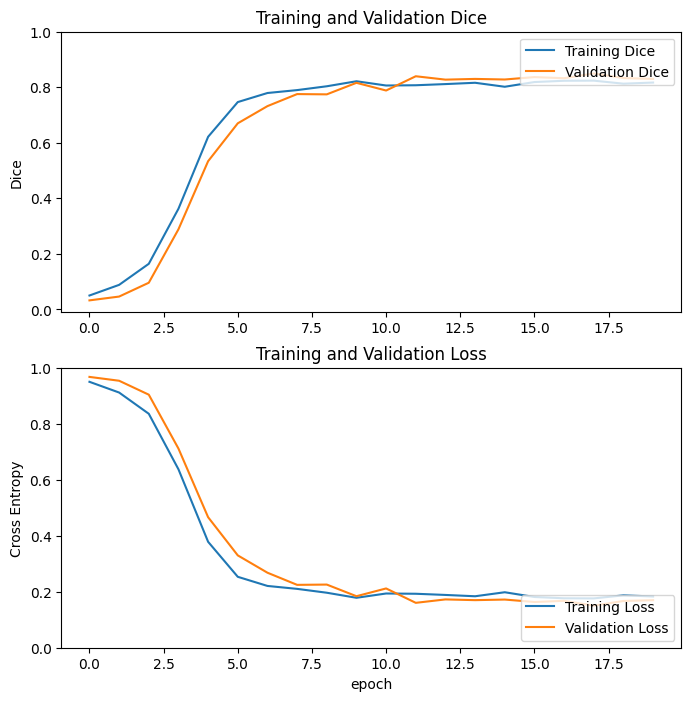

In [51]:
acc = hist.history['dice_coefficient']
val_acc = hist.history['val_dice_coefficient']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Dice')
plt.plot(val_acc, label='Validation Dice')
plt.legend(loc='upper right')
plt.ylabel('Dice')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Dice')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='lower right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Оценка качества

In [52]:
# model1-model5 Достаточно прогнать 1 раз
# dice1 = predict(model1, testTiles)[0]
# dice2 = predict(model2, testTiles)[0]
# dice3 = predict(model3, testTiles)[0]
# dice4 = predict(model4, testTiles)[0]
# dice5 = predict(model5, testTiles)[0]

# Тут ошибка
# dice_ensemble = predict(ensemble_model, testTiles, num_models=2)[0];
dice_ensemble = predict(ensemble_model, testTiles, num_models=len(members))[0]

3
here


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 [==============================] - 1s 851ms/step
here


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 [==============================] - 1s 872ms/step
here
1/1 [==============================] - 0s 174ms/step


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


here
1/1 [==============================] - 0s 151ms/step
here
1/1 [==============================] - 0s 145ms/step
here
1/1 [==============================] - 0s 168ms/step
here


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 [==============================] - 0s 167ms/step
here
1/1 [==============================] - 0s 213ms/step
here
1/1 [==============================] - 0s 192ms/step
here
1/1 [==============================] - 0s 221ms/step
here
1/1 [==============================] - 1s 875ms/step
here
1/1 [==============================] - 1s 723ms/step


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


here
1/1 [==============================] - 0s 224ms/step
here
1/1 [==============================] - 0s 142ms/step


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


here
1/1 [==============================] - 0s 148ms/step
here
1/1 [==============================] - 0s 250ms/step
here
1/1 [==============================] - 0s 144ms/step


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


here
1/1 [==============================] - 0s 154ms/step
here
1/1 [==============================] - 0s 221ms/step
here
1/1 [==============================] - 1s 597ms/step
here


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 [==============================] - 0s 144ms/step
here
1/1 [==============================] - 1s 554ms/step
here


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 [==============================] - 0s 145ms/step
here
1/1 [==============================] - 0s 156ms/step
here
1/1 [==============================] - 0s 146ms/step
here
1/1 [==============================] - 1s 832ms/step
here
1/1 [==============================] - 1s 523ms/step
here


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 [==============================] - 1s 671ms/step
here
1/1 [==============================] - 0s 141ms/step


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


here
1/1 [==============================] - 0s 144ms/step
here
1/1 [==============================] - 0s 144ms/step
here
1/1 [==============================] - 0s 251ms/step
here
1/1 [==============================] - 1s 538ms/step
here


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 [==============================] - 1s 806ms/step
here
1/1 [==============================] - 0s 139ms/step


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


here
1/1 [==============================] - 1s 542ms/step
here
1/1 [==============================] - 0s 141ms/step


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


here
1/1 [==============================] - 0s 147ms/step
here
1/1 [==============================] - 0s 143ms/step
here
1/1 [==============================] - 0s 150ms/step
here
1/1 [==============================] - 1s 690ms/step
here


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 [==============================] - 0s 200ms/step
here
1/1 [==============================] - ETA: 0s

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 [==============================] - 0s 158ms/step
here
1/1 [==============================] - 0s 158ms/step
here
1/1 [==============================] - 0s 153ms/step
here


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 [==============================] - 0s 154ms/step
here
1/1 [==============================] - 0s 142ms/step
here
1/1 [==============================] - 0s 141ms/step
here
1/1 [==============================] - 0s 164ms/step
here


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 [==============================] - 0s 150ms/step
here
1/1 [==============================] - 0s 145ms/step
here
1/1 [==============================] - 0s 163ms/step
here


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 [==============================] - 0s 156ms/step
here
1/1 [==============================] - 0s 303ms/step
here
1/1 [==============================] - 0s 146ms/step


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


here
1/1 [==============================] - 0s 153ms/step
here
1/1 [==============================] - 0s 137ms/step
here
1/1 [==============================] - 1s 968ms/step
here
1/1 [==============================] - 1s 724ms/step


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


here
1/1 [==============================] - 0s 251ms/step
here


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 [==============================] - 0s 235ms/step
here
1/1 [==============================] - 0s 181ms/step
here
1/1 [==============================] - 1s 706ms/step
here


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 [==============================] - 0s 159ms/step
here
1/1 [==============================] - 0s 238ms/step
here
1/1 [==============================] - 0s 150ms/step


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


here
1/1 [==============================] - 0s 158ms/step
here
1/1 [==============================] - 0s 148ms/step


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


here
1/1 [==============================] - 1s 580ms/step
here
1/1 [==============================] - 0s 143ms/step


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


here
1/1 [==============================] - 0s 142ms/step
here
1/1 [==============================] - 0s 148ms/step
here
1/1 [==============================] - 0s 171ms/step
here
1/1 [==============================] - 0s 136ms/step


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


here
1/1 [==============================] - 0s 145ms/step
here
1/1 [==============================] - 0s 228ms/step
here
1/1 [==============================] - 0s 138ms/step


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


here
1/1 [==============================] - 0s 145ms/step
here
1/1 [==============================] - 0s 138ms/step
here
1/1 [==============================] - 1s 899ms/step
here
1/1 [==============================] - 0s 173ms/step


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


here
1/1 [==============================] - 0s 148ms/step


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


here
1/1 [==============================] - 0s 141ms/step
here
1/1 [==============================] - 1s 850ms/step
here


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 [==============================] - 1s 782ms/step
here


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 [==============================] - 0s 166ms/step
here
1/1 [==============================] - 0s 493ms/step


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


here


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 [==============================] - 1s 680ms/step
here
1/1 [==============================] - 0s 142ms/step


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


here
1/1 [==============================] - 1s 861ms/step
here


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 [==============================] - 0s 171ms/step
here
1/1 [==============================] - 0s 145ms/step


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


here
1/1 [==============================] - 0s 142ms/step
here
1/1 [==============================] - 0s 149ms/step
here
1/1 [==============================] - 1s 729ms/step
here
1/1 [==============================] - 0s 161ms/step


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


here
1/1 [==============================] - 1s 535ms/step
here
1/1 [==============================] - 0s 144ms/step


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


here
1/1 [==============================] - 0s 146ms/step
here
1/1 [==============================] - 0s 143ms/step
here
1/1 [==============================] - 0s 155ms/step
here
1/1 [==============================] - 1s 581ms/step
here
1/1 [==============================] - 0s 163ms/step


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


here
1/1 [==============================] - 0s 141ms/step
here
1/1 [==============================] - 0s 140ms/step
here
1/1 [==============================] - 0s 177ms/step
here
1/1 [==============================] - 0s 143ms/step


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


here
1/1 [==============================] - 0s 143ms/step
here
1/1 [==============================] - 0s 235ms/step
here


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 [==============================] - 1s 738ms/step
here


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 [==============================] - 0s 158ms/step
here
1/1 [==============================] - 0s 400ms/step
here


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 [==============================] - 1s 822ms/step
here


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 [==============================] - 0s 236ms/step
here
1/1 [==============================] - 0s 151ms/step
here
1/1 [==============================] - 1s 916ms/step
here


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 [==============================] - 0s 177ms/step


In [53]:
# model1-model5 Достаточно прогнать 1 раз
# print('Dice Score for model1 = ', dice1.numpy())
# print('Dice Score for model2 = ', dice2.numpy())
# print('Dice Score for model3 = ', dice3.numpy())
# print('Dice Score for model4 = ', dice4.numpy())
# print('Dice Score for model5 = ', dice5.numpy())

print({
    'ModelName': MODEL_NAME,
    'LR': lr,
    'EPOCHS': epochs,
    "BS": batch,
    "HS": hidden_size,
})
print('Dice Score for stacking ensemble =', str(dice_ensemble.numpy()).replace('.', ',') + '.')

{'ModelName': '09.05-17:47:06_model1_model3_model4', 'LR': 0.002, 'EPOCHS': 20, 'BS': 16, 'HS': 32}
Dice Score for stacking ensemble = 0,7773774.
